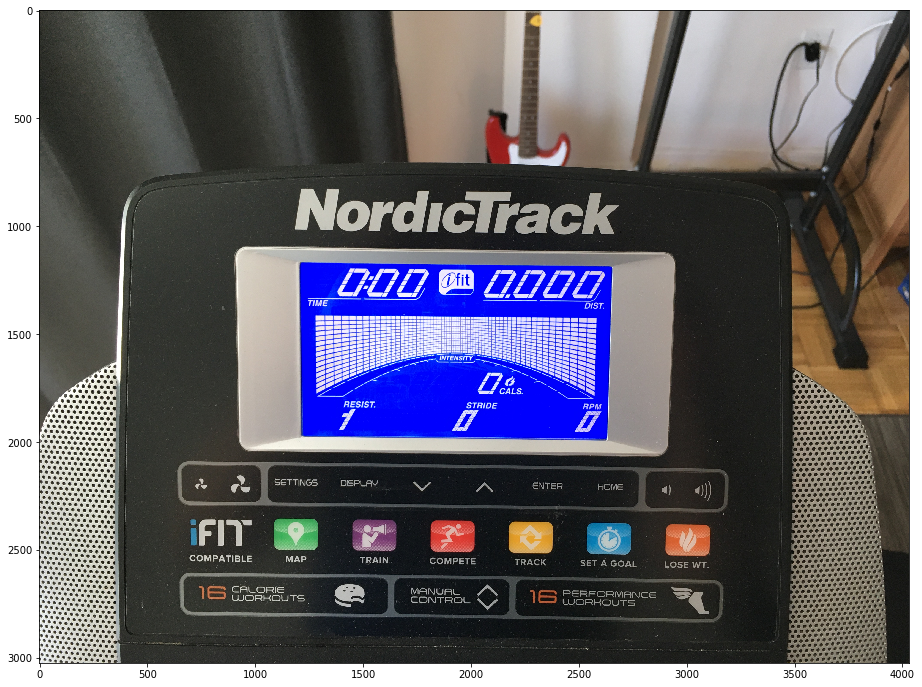

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import imutils
import numpy as np

image = cv2.imread('IMG_1101.jpg', cv2.IMREAD_COLOR)
#image = cv2.imread('IMG_1102.jpg', cv2.IMREAD_COLOR)
#image = cv2.imread('IMG_1103.jpg', cv2.IMREAD_COLOR)
#image = cv2.imread('IMG_1104.jpg', cv2.IMREAD_COLOR)
#image = cv2.imread('IMG_1105.jpg', cv2.IMREAD_COLOR)
#image = cv2.imread('IMG_1106.jpg', cv2.IMREAD_COLOR)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(16, 12))
plt.imshow(image)

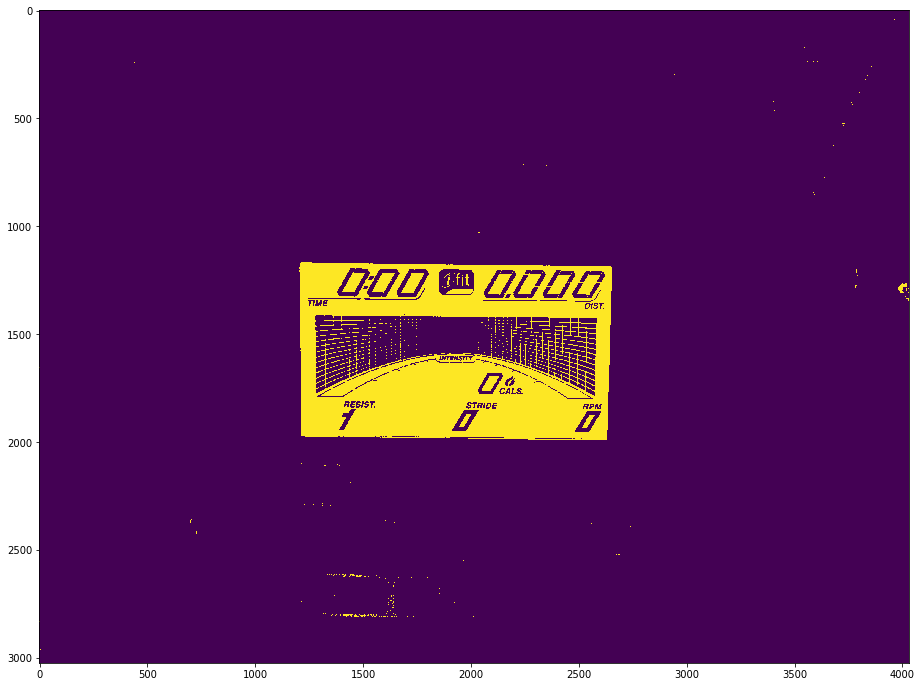

In [2]:
min_blue = np.array([0, 0, 100], dtype='uint8')
max_blue = np.array([100, 100, 255], dtype='uint8')
mask = cv2.inRange(image, min_blue, max_blue)
plt.figure(figsize=(16, 12))
plt.imshow(mask)

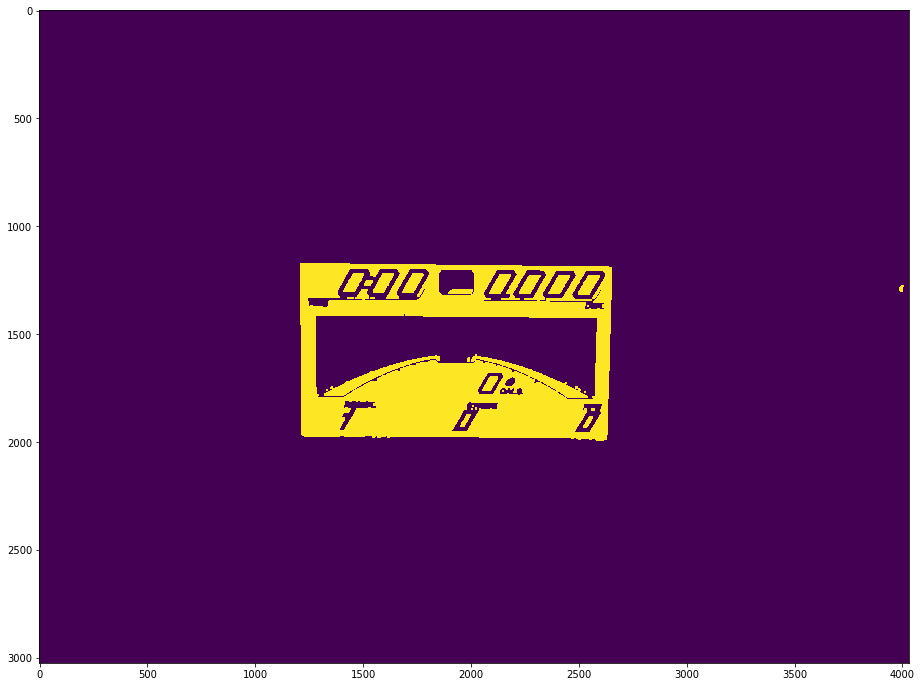

In [3]:
mask_kernel = np.ones((10, 10), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, mask_kernel)
plt.figure(figsize=(16, 12))
plt.imshow(mask)

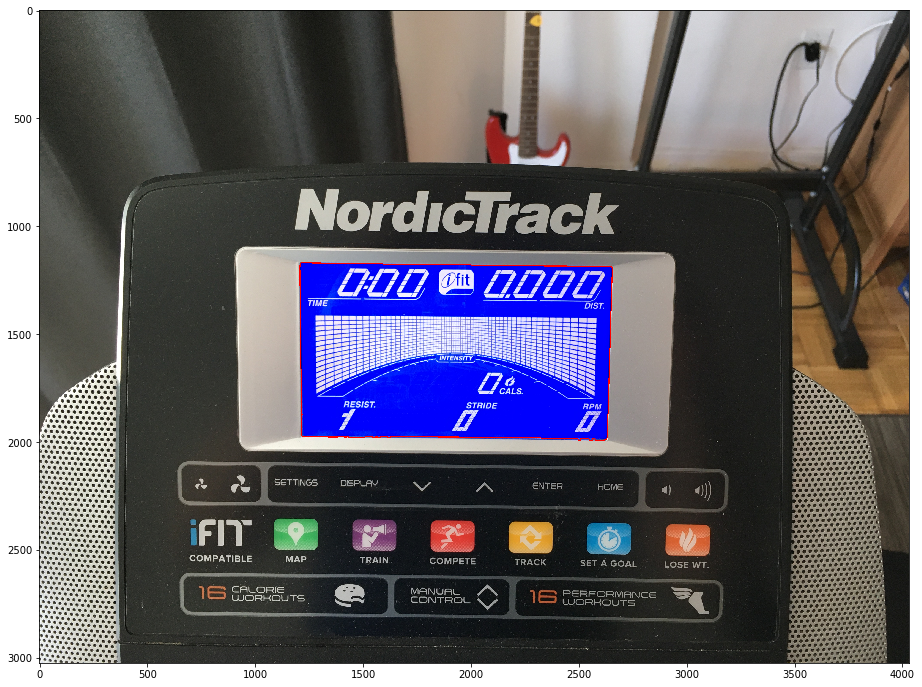

In [4]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key = cv2.contourArea)

image_with_contours = cv2.drawContours(image.copy(), [largest_contour], -1, (255, 0, 0), 3)
plt.figure(figsize=(16, 12))
plt.imshow(image_with_contours)

Got 4 vertices


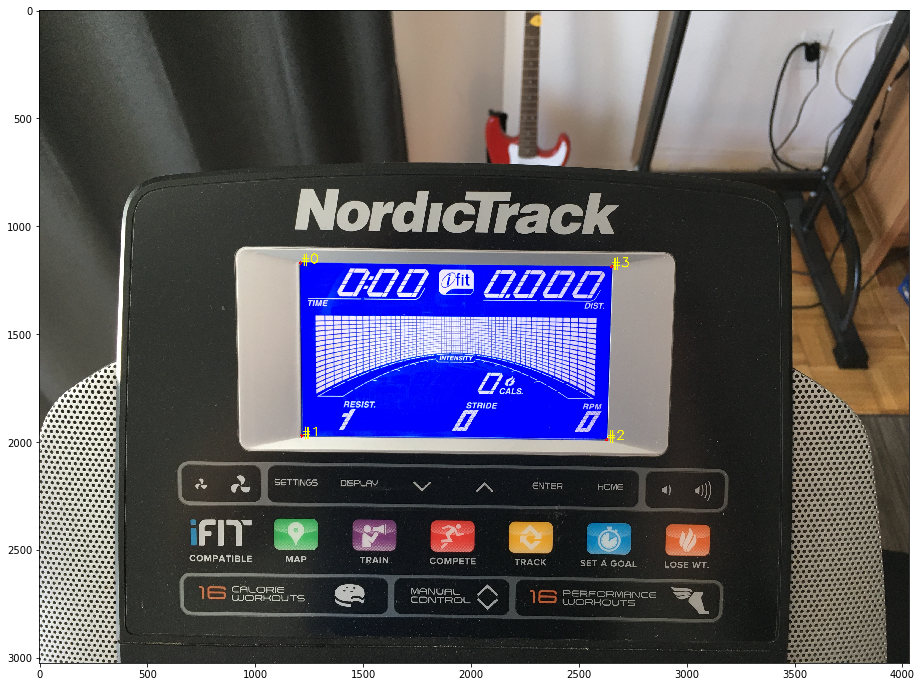

In [5]:
epsilon = 0.1 * cv2.arcLength(largest_contour, True)
vertices = [(v[0][0], v[0][1]) for v in cv2.approxPolyDP(largest_contour, epsilon, True)]
print(f'Got {len(vertices)} vertices')

image_with_circles = image.copy()
for i, (x, y) in enumerate(vertices):
    image_with_circles = cv2.circle(
        image_with_circles, 
        (x, y), 
        5, 
        (255, 0, 0), 
        3)
    cv2.putText(image_with_circles, f'#{i}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 3, cv2.LINE_AA)
    
plt.figure(figsize=(16, 12))
plt.imshow(image_with_circles)

True

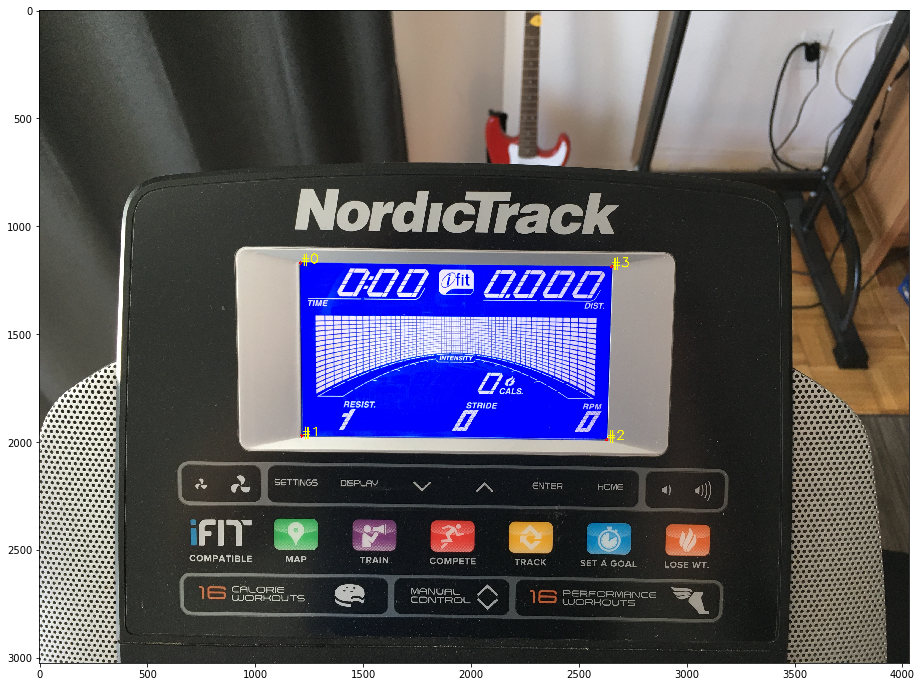

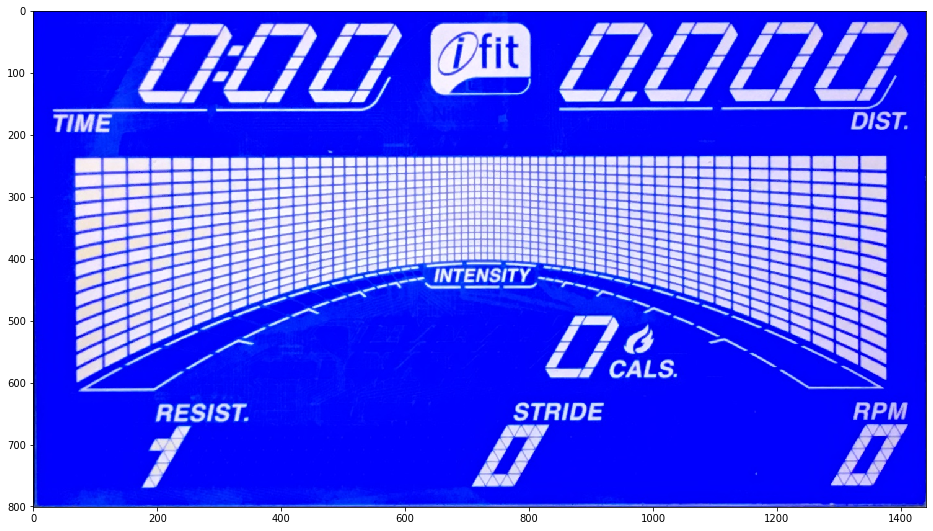

In [6]:
if len(vertices) != 4:
    raise Exception(f'Expected 4 vertices, got {len(vertices)}')

center = (
    (vertices[0][0] + vertices[1][0] + vertices[2][0] + vertices[3][0]) / 4,
    (vertices[0][1] + vertices[1][1] + vertices[2][1] + vertices[3][1]) / 4
)

top_left = [v for v in vertices if v[0] < center[0] and v[1] < center[1]][0]
bottom_left = [v for v in vertices if v[0] < center[0] and v[1] > center[1]][0]
bottom_right = [v for v in vertices if v[0] > center[0] and v[1] > center[1]][0]
top_right = [v for v in vertices if v[0] > center[0] and v[1] < center[1]][0]
vertices = (top_left, bottom_left, bottom_right, top_right)

image_with_circles2 = image.copy()
for i, (x, y) in enumerate(vertices):
    image_with_circles2 = cv2.circle(
        image_with_circles2, 
        (x, y), 
        5, 
        (255, 0, 0), 
        3)
    cv2.putText(image_with_circles2, f'#{i}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 3, cv2.LINE_AA)

plt.figure(figsize=(16, 12))
plt.imshow(image_with_circles2)

w = max(abs(top_left[0]-top_right[0]), abs(bottom_left[0]-bottom_right[0]))
h = max(abs(top_left[1]-bottom_left[1]), abs(top_right[1]-bottom_right[1]))

perspective_matrix = cv2.getPerspectiveTransform(
    np.array([
        [vertices[0][0], vertices[0][1]],
        [vertices[1][0], vertices[1][1]],
        [vertices[2][0], vertices[2][1]],
        [vertices[3][0], vertices[3][1]]
    ], dtype='float32'),
    np.array([
        [0,0],
        [0,h-1],
        [w-1,h-1],
        [w-1,0]
    ], dtype='float32')
)
warped_image = cv2.warpPerspective(image, perspective_matrix, (w, h))
plt.figure(figsize=(16, 12))
plt.imshow(warped_image)

cv2.imwrite('template.png', cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))

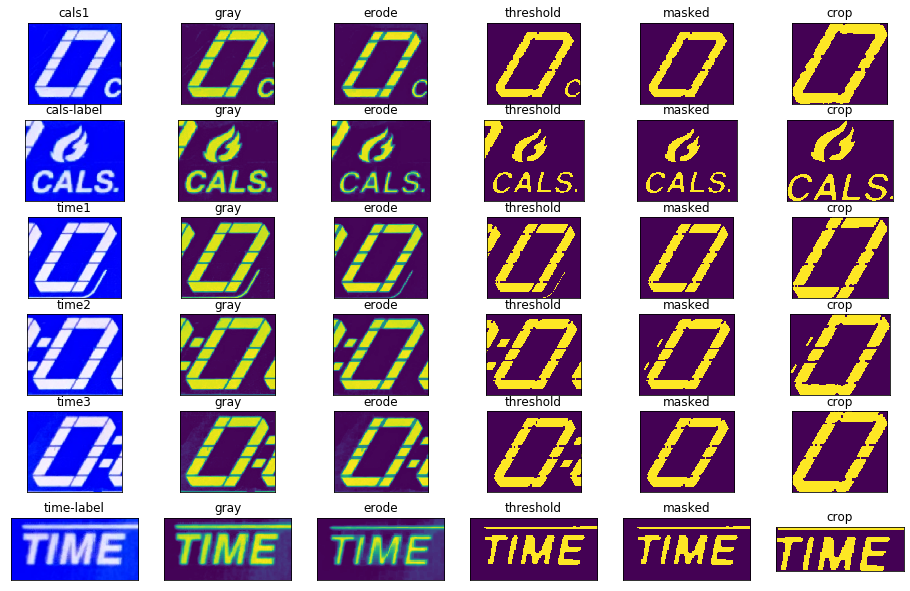

In [7]:
from PIL import Image, ImageSequence, TiffTags

TIFF_PAGE_NAME_TAG_ID = [k for k,v in TiffTags.TAGS.items() if v == 'PageName'][0]

image = Image.open('template.tif')
layers = {}
for layer in ImageSequence.Iterator(image):
    layer_name = layer.tag[TIFF_PAGE_NAME_TAG_ID][0]
    layer_image = np.array(layer.convert('RGB'))
    layers[layer_name] = layer_image

background_image = layers['background']
warped_resized_image = cv2.resize(warped_image.copy(), (background_image.shape[1], background_image.shape[0]))

plt.figure(figsize=(16, 14))

for i, layer_name in enumerate([k for k in layers.keys() if k != 'background']):
    mask_image = layers[layer_name]
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_RGB2GRAY)
    contours, hierarchy = cv2.findContours(mask_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 1:
        raise Exception(f'{layer_name} - expected exactly one contour, got {len(contours)}')
    mask_x, mask_y, mask_w, mask_h = cv2.boundingRect(contours[0])
    
    digit_image = warped_resized_image[mask_y:mask_y+mask_h, mask_x:mask_x+mask_w]
    plt.subplot(8, 6, 6*i+1)
    plt.title(layer_name)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(digit_image)
    
    digit_image = cv2.cvtColor(digit_image, cv2.COLOR_RGB2GRAY)
    plt.subplot(8, 6, 6*i+2)
    plt.title('gray')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(digit_image)
    
    digit_image = cv2.erode(digit_image, np.ones((2, 2), np.uint8), iterations=2)
    plt.subplot(8, 6, 6*i+3)
    plt.title('erode')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(digit_image)
    
    ret, digit_image = cv2.threshold(digit_image, 127, 255, cv2.THRESH_BINARY)
    plt.subplot(8, 6, 6*i+4)
    plt.title('threshold')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(digit_image)
    
    digit_image = cv2.bitwise_and(digit_image, digit_image, 
                                  mask=mask_image[mask_y:mask_y+mask_h, mask_x:mask_x+mask_w])
    plt.subplot(8, 6, 6*i+5)
    plt.title('masked')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(digit_image)
    
    nonzero_coords = cv2.findNonZero(digit_image)
    if nonzero_coords is None:
        raise Exception(f'{layer_name} non-zero coords is empty')
    
    nonzero_x, nonzero_y, nonzero_w, nonzero_h = cv2.boundingRect(nonzero_coords)
    digit_image = digit_image[nonzero_y:nonzero_y+nonzero_h, nonzero_x:nonzero_x+nonzero_w]
    plt.subplot(8, 6, 6*i+6)
    plt.title('crop')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(digit_image)